In [ ]:
# https://population.un.org/wpp/Download/Standard/CSV/
# https://ourworldindata.org/explorers/animal-welfare

In [151]:
import polars as pl
import matplotlib.pyplot as plt

meat = pl.read_csv("animal-welfare.csv")
populations = pl.read_csv("WPP2022_PopulationBySingleAgeSex_Medium_1950-2021.csv", ignore_errors=True)

locations = ["United Kingdom", "France", "Germany", "Italy", "Spain", "Poland"]

In [162]:
agg_pop = (populations
 .select("Location", "Time", "PopTotal")
 .group_by(["Location", "Time"]).agg(Population=pl.col("PopTotal").sum())
 .with_columns(Location=pl.col("Location").str.replace("United States of America", "United States"),
               Population=pl.col("Population") * 1000)
)

In [164]:
data = (meat
 .filter(pl.col("Entity").is_in(locations))
 .select("Entity", "Year", Meat_Production=pl.col("Meat, total | 00001765 || Producing or slaughtered animals | 005320 || animals"))
 .join(agg_pop, left_on=["Entity", "Year"], right_on=["Location", "Time"], how="inner")
 .sort(["Entity", "Year"])
 .with_columns(Meat_Production_Per_Capita=pl.col("Meat_Production") / pl.col("Population"))
)

In [165]:
data_mp = data.pivot(index="Year", columns="Entity", values="Meat_Production")
data_pop = data.pivot(index="Year", columns="Entity", values="Population")
data_mppc = data.pivot(index="Year", columns="Entity", values="Meat_Production_Per_Capita")

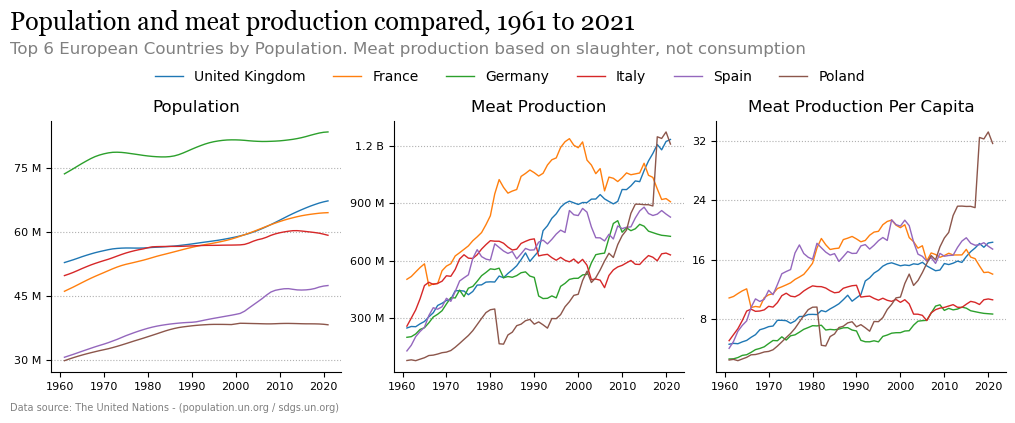

In [180]:
def units_pop(x, pos):
    """The two arguments are the value and tick position."""
    return f'{x / 10 ** 6:1.0f} M'

def units_prod(x, pos):
    """The two arguments are the value and tick position."""
    if x > 1_000_000_000:
        return f'{x / 10 ** 9:1.1f} B'
    else:
        return f'{x / 10 ** 6:1.0f} M'

def units_per_capita(x, pos):
    """The two arguments are the value and tick position."""
    return f'{x:1.0f}'


ax = plt.figure(layout="constrained", figsize=(10,3)).subplot_mosaic(
    """
    ABC
    """
)

plots = ["A", "B", "C"]
plot_names = ["Population", "Meat Production", "Meat Production Per Capita"]
units = [units_pop, units_prod, units_per_capita]

for location in locations:
    line1 = ax[plots[0]].plot(data_pop["Year"], data_pop[location], 
                              label="Population", linewidth=1)
    line2 = ax[plots[1]].plot(data_mp["Year"], data_mp[location], 
                              label="Meat Production", linewidth=1)
    line2 = ax[plots[2]].plot(data_mppc["Year"], data_mppc[location], 
                              label="Meat Production Per Capita", linewidth=1)
    
for i, plot in enumerate(plots):
    ax[plot].set_title(plot_names[i])
    ax[plot].yaxis.set_major_formatter(units[i])
    ax[plot].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[plot].tick_params(axis="both", labelsize=8)
    ax[plot].spines["top"].set_visible(False)
    ax[plot].spines["right"].set_visible(False)
    ax[plot].grid(axis="y", linestyle="dotted")   

plt.figtext(0, 1.22, 
            "Population and meat production compared, 1961 to 2021", 
            fontsize=18, ha="left",
            fontdict={'fontname': 'Georgia'})

plt.figtext(0, 1.14, 
            "Top 6 European Countries by Population. Meat production based on slaughter, not consumption", 
            fontsize=12, ha="left", 
            fontdict={"color": "grey"})

plt.figtext(0, -0.05, 
            "Data source: The United Nations - (population.un.org / sdgs.un.org)",
            fontsize=7, ha='left', 
            fontdict={"color": "grey"})

plt.figlegend(locations, 
              loc="upper center", 
              bbox_to_anchor=(0.5, 1.13), 
              ncols=len(locations),
              frameon=False)

plt.show()